# SRGAN
This notebook will contain demonstrations on how to train and use the SRGAN network. 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

from libs.srgan import SRGAN
from libs.util import plot_test_images, DataLoader

Using TensorFlow backend.


# 1. Loading Data

## 1.2. Training on ImageNet

In [ ]:
# Settings (CHANGE THESE)
IMAGENET_TRAIN = 'C:/Documents/Kaggle/Kaggle-imagenet/input/DET/train'
IMAGENET_TEST = 'C:/Documents/Kaggle/Kaggle-imagenet/input/DET/test'
log_test_images = [
    'C:/Documents/Kaggle/Kaggle-imagenet/input/DET/pexels/pexels-photo-1171853.jpeg',
    'C:/Documents/Kaggle/Kaggle-imagenet/input/DET/pexels/pexels-photo-342257.jpeg',
    'C:/Documents/Kaggle/Kaggle-imagenet/input/DET/pexels/pexels-photo-1018484.jpeg',
    'C:/Documents/Kaggle/Kaggle-imagenet/input/DET/pexels/pexels-photo-850602.jpeg',
]

# Common settings for all training stages
common = {
    "batch_size": 16, 
    "workers":7,
    "datapath_train":IMAGENET_TRAIN,    
    "log_weight_path":'./data/weights/', 
    "log_tensorboard_path":'./data/logs/',
    "log_test_images":log_test_images,
    "log_test_path":"./images/samples2/"
}

# Create the SRGAN model
gan = SRGAN()
gan.train_generator(
    epochs=10,
    dataname='SRResNet_imagenet',
    datapath_test=IMAGENET_TEST,
    steps_per_epoch=100000,
    steps_per_validation=1000,
    log_tensorboard_name='SRResNet_imagenet',
    log_tensorboard_update_freq=1000,
    **common
)

# Train the GAN
gan.train_srgan(
    epochs=100000,
    dataname='SRGAN_imagenet',
    print_frequency=5000,    
    log_weight_frequency=5000,
    log_tensorboard_name='SRGAN_imagenet',
    log_test_frequency=10000,
    first_epoch=1000000,
    **common
)

# Fine tune model
gan = SRGAN(gen_lr=1e-5, dis_lr=1e-5)
gan.load_weights(
    './data/weights/SRGAN_imagenet1095000_generator.h5',
    './data/weights/SRGAN_imagenet1095000_discriminator.h5'
)
gan.train_srgan(
    epochs=100000,
    dataname='SRGAN_imagenet',
    print_frequency=5000,    
    log_weight_frequency=5000,
    log_tensorboard_name='SRGAN_imagenet',
    log_test_frequency=10000,
    first_epoch=1100000,
    **common
)

# 2. Running Inference

In [2]:
gan = SRGAN(training_mode=True)
gan.load_weights(
    './data/weights/SRGAN_imagenet1195000_generator.h5',
    './data/weights/SRGAN_imagenet1195000_discriminator.h5'
)

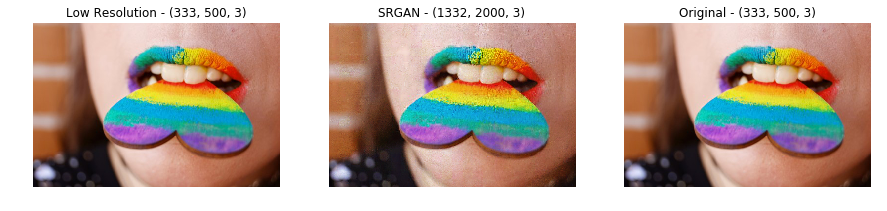

In [3]:
# Load image
img_hr = DataLoader.load_img("C:/Documents/Kaggle/Kaggle-imagenet/input/DET/pexels/pexels-photo-1171853.jpeg").astype(np.uint8)

# Create a low-resolution version of it
lr_shape = (int(img_hr.shape[1]/4), int(img_hr.shape[0]/4))
img_lr = Image.fromarray(img_hr)
#img_lr = img_lr.resize(lr_shape, Image.BICUBIC)
img_lr = np.array(img_lr)

# Scale images
img_lr = DataLoader.scale_lr_imgs(img_lr)

# Predict high-resolution version (add batch dimension to image)
img_sr = np.squeeze(
    gan.generator.predict(
        np.expand_dims(img_lr, 0),
        batch_size=1
    ),
    axis=0
)

# Unscale
img_sr = DataLoader.unscale_hr_imgs(img_sr).astype(np.uint8)
img_lr = DataLoader.unscale_lr_imgs(img_lr).astype(np.uint8)

# Images and titles
images = {
    'Low Resolution': img_lr, 'SRGAN': img_sr, 'Original': img_hr
}

# Plot the images. Note: rescaling and using squeeze since we are getting batches of size 1                    
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (title, img) in enumerate(images.items()):
    axes[i].imshow(img)
    axes[i].set_title("{} - {}".format(title, img.shape))
    axes[i].axis('off')
plt.show()